In [201]:
#-----------------------------
# Packages Import
#-----------------------------
%matplotlib inline

import cv2
import numpy as np
from matplotlib import pyplot as plt
import os


In [202]:
#-----------------------------
# Imports a Test Image 
#-----------------------------
PathTest1= "C:\\Users\\usuario\\Desktop\\Knot-Images-to-regina-code\\data\\Test-Knot.jpg"
PathTest2= "C:\\Users\\usuario\\Desktop\\Knot-Images-to-regina-code\\data\\Test2-Knot.jpg"

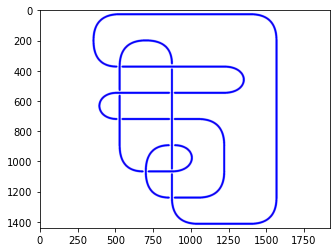

In [203]:
'''
This code will find the countours of the link as a jpg image
'''
test_image=PathTest2

image= cv2.imread(test_image)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Blur and threshold to isolate the knot
blurred = cv2.GaussianBlur(gray, (15, 15), 0)


'''
Work which Thresholding method might be the better and more efficient for the current project
'''
_, thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY_INV)
#thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)


contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST , cv2.CHAIN_APPROX_SIMPLE)

image_with_countours=cv2.drawContours(image, contours, -1, (0,0,255), 5)

plt.imshow(image_with_countours)


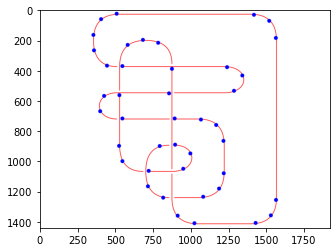

In [204]:
''' 
This clears the image
'''
image= cv2.imread(test_image)

rect_dim=[200,200]

half_w = rect_dim[0] / 2
half_h = rect_dim[1] / 2

"""
Filter points so that no two points are within the same 
rectangle defined by rect_dim (width, height).
"""
# 1. Flatten the contour to a simple list of (x, y) coordinates
points=[]
for component in contours:
    points_in_countours = [point.tolist()[0] for point in component]
    points+=points_in_countours

    
filtered_points = []
# Convert to set or list we can manipulate
remaining_points = points


while remaining_points:
    # Pick the first point in the list
    current = remaining_points.pop(0)
    filtered_points.append(current)
    
    #print(current[0])
    cx, cy = current
    
    # 2. Filter out all points that fall inside the rectangle centered at (cx, cy)
    # We use a list comprehension to keep only points OUTSIDE the box
    remaining_points = [
        p for p in remaining_points 
        if not (cx - half_w <= p[0] <= cx + half_w and 
                cy - half_h <= p[1] <= cy + half_h)
    ]

#print(contours)
#print(points[0])    


filtered_points_for_draw=np.array([[point] for point in filtered_points])

#print(filtered_points_for_draw)

image_with_fil=cv2.drawContours(image, filtered_points_for_draw, -1, (0,0,255), 25)
plt.imshow(image)

In [205]:
'''
So far we extracted the important point of the image.
The idea now is to use machine learning to move a window following the knot.
The window starts at a point of the above 
The windows moves according to the ML model 
Is is checked whether one of the important points is there, if yes it adds it to a list and records its order
otherwise continues in a while loop until it returns to the original point
If not all points were recorded that means is a link and one should do the same for the other link components

How does the window move:

The ML has 8*3*2 possible values: (N, NW, NE, E, W, S, SW, SE, over-crossing* CadinalDirection* which strands are we, under-crossing*CardinalDirection*which strand are we)
If the probability of crossing is low, then in moves acording to the probabilities obtained in the corresponding direction
If the crossing probability is high it moves in the correct crossing direction and records the over or under crossing. 

ML architecture:
The outputs are 8+8*2+8*2= 40.
The inputs are images of pixels x pixels.

'''

'\nSo far we extracted the important point of the image.\nThe idea now is to use machine learning to move a window following the knot.\nThe window starts at a point of the above \nThe windows moves according to the ML model \nIs is checked whether one of the important points is there, if yes it adds it to a list and records its order\notherwise continues in a while loop until it returns to the original point\nIf not all points were recorded that means is a link and one should do the same for the other link components\n\nHow does the window move:\n\nThe ML has 8*3*2 possible values: (N, NW, NE, E, W, S, SW, SE, over-crossing* CadinalDirection* which strands are we, under-crossing*CardinalDirection*which strand are we)\nIf the probability of crossing is low, then in moves acording to the probabilities obtained in the corresponding direction\nIf the crossing probability is high it moves in the correct crossing direction and records the over or under crossing. \n\nML architecture:\nThe out

In [ ]:
'''Next goal is to create a code that generates a random sample of local knots to train the mode'''

'''Next goal is to crate the Neural network '''

'\n# --- Main Generation Loop ---\ndataset_labels = []\n\nfor i in range(NUM_IMAGES):\n    # Initialize a clean, gray background\n    img = np.full((WINDOW_SIZE[1], WINDOW_SIZE[0], 3), 128, dtype=np.uint8)\n    \n    # 1. Randomize standard movement (The "Main Strand")\n    # We pick an \'in\' direction and an \'out\' direction that isn\'t the same.\n    in_idx = random.randint(0, 7)\n    out_idx = (in_idx + random.randint(3, 5)) % 8 # Ensure logical forward flow\n    \n    angle_in = DIRECTIONS[DIR_KEYS[in_idx]]\n    angle_out = DIRECTIONS[DIR_KEYS[out_idx]]\n    \n    # Label parts\n    crossing_type = "NONE" # NONE, OVER, UNDER\n    strand_id = 0 # Dummy for now, useful if you track multiple strands\n    \n    # 2. Decide if this is a crossing (33% No, 33% Over, 33% Under)\n    cross_choice = random.random()\n    \n    # Primary rope color (e.g., Red-ish like your sample)\n    rope_color = (60, 60, 180) \n\n    if cross_choice < 0.33:\n        # State: NO CROSSING\n        draw_stra

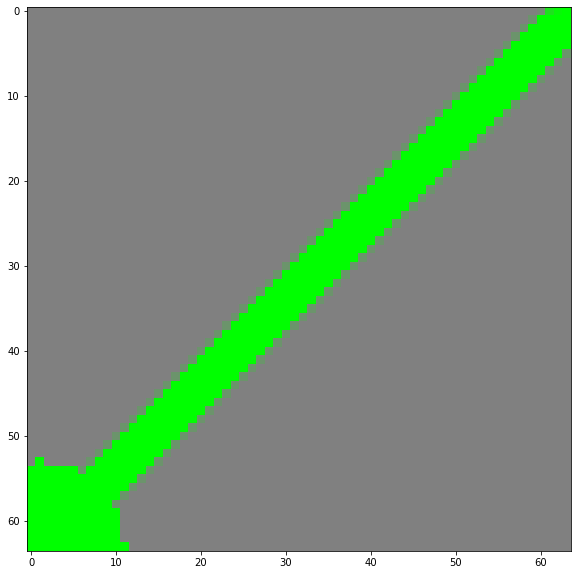

In [239]:
'''
This code generates randow images
'''
import random
import os
import json
import math
import matplotlib.pyplot as plt

# --- Configuration ---
# Match your ML model's expected input
WINDOW_SIZE = (64, 64) 
ROPE_RADIUS = 2
OUTPUT_DIR = "knot_training_data"
NUM_IMAGES = 1000 # Start with this to test

# Mapping cardinal directions to approximate angles (in radians)
# Starting N at -90 degrees (standard Cartesian setup in image space)
DIRECTIONS = {
    "N":  -math.pi/2, "NE": -math.pi/4, "E": 0, "SE": math.pi/4,
    "S":   math.pi/2, "SW": 3*math.pi/4, "W": math.pi, "NW": -3*math.pi/4
}
DIR_KEYS = list(DIRECTIONS.keys())

# Ensure output directory exists
#os.makedirs(OUTPUT_DIR, exist_ok=True)
#os.makedirs(os.path.join(OUTPUT_DIR, "images"), exist_ok=True)

def get_boundary_point(angle, size):
    """Calculates where a line at 'angle' hits the image boundary."""
    h, w = size
    cx, cy = w // 2, h // 2
    
    # Large distance to ensure we hit the boundary
    dist = max(w, h)
    
    x1 = int(cx - dist * math.cos(angle))
    y1 = int(cy - dist * math.sin(angle))
    x2 = int(cx + dist * math.cos(angle))
    y2 = int(cy + dist * math.sin(angle))
    
    #_,p1,p2=cv2.clipLine((0, 0, w, h), (-10,-10 ), (200, 200))
    # Clip line to image boundaries
    _,p1,p2 = cv2.clipLine((0, 0, w, h), (x1, y1), (x2, y2))
    return [p1,p2] 


#This function Draws a line going thorugh the center given the angle
def draw_strand(img, angle, thickness):
    """Draws a smooth 'rope' strand through the center."""
    h, w = img.shape[:2]
    cx, cy = w // 2, h // 2
    
    p_in, p_out= get_boundary_point(angle, (h, w))
    
    cv2.line(img, p_in, p_out, (0,255,0), thickness, cv2.LINE_AA)
    cv2.circle(img,p_in, 10, (0,255,0), -1)
    return p_in, p_out



# Initialize a clean, gray background
img = np.full((WINDOW_SIZE[1], WINDOW_SIZE[0], 3), 128, dtype=np.uint8)



# 4. Create the plot
plt.figure(figsize=(10, 10))
plt.imshow(img)


# 1. Randomize standard movement (The "Main Strand")
in_idx = random.randint(0, 7)
angle = DIRECTIONS[DIR_KEYS[in_idx]]


# Label parts
#crossing_type = "NONE" # NONE, OVER, UNDER
#strand_id = 0 # Dummy for now, useful if you track multiple strands

# 2. Decide if this is a crossing (33% No, 33% Over, 33% Under)
#cross_choice = random.random()

# Primary rope color (e.g., Red-ish like your sample)
#rope_color = (60, 60, 180) 


draw_strand(img, angle, ROPE_RADIUS * 2)

plt.imshow(img)

'''
# --- Main Generation Loop ---
dataset_labels = []

for i in range(NUM_IMAGES):
    # Initialize a clean, gray background
    img = np.full((WINDOW_SIZE[1], WINDOW_SIZE[0], 3), 128, dtype=np.uint8)
    
    # 1. Randomize standard movement (The "Main Strand")
    # We pick an 'in' direction and an 'out' direction that isn't the same.
    in_idx = random.randint(0, 7)
    out_idx = (in_idx + random.randint(3, 5)) % 8 # Ensure logical forward flow
    
    angle_in = DIRECTIONS[DIR_KEYS[in_idx]]
    angle_out = DIRECTIONS[DIR_KEYS[out_idx]]
    
    # Label parts
    crossing_type = "NONE" # NONE, OVER, UNDER
    strand_id = 0 # Dummy for now, useful if you track multiple strands
    
    # 2. Decide if this is a crossing (33% No, 33% Over, 33% Under)
    cross_choice = random.random()
    
    # Primary rope color (e.g., Red-ish like your sample)
    rope_color = (60, 60, 180) 

    if cross_choice < 0.33:
        # State: NO CROSSING
        draw_strand(img, angle_in, angle_out, rope_color, ROPE_RADIUS * 2)
        
    else:
        # State: WE HAVE A CROSSING
        # Create a second, secondary strand 'cut'
        angle_in2 = DIRECTIONS[DIR_KEYS[(in_idx + 2) % 8]]
        angle_out2 = DIRECTIONS[DIR_KEYS[(out_idx + 2) % 8]]
        secondary_color = (180, 60, 60) # Different color helps ML distinguish

        if cross_choice < 0.66:
            # State: OVER-CROSSING
            crossing_type = "OVER"
            # Draw secondary strand FIRST (it goes underneath)
            draw_strand(img, angle_in2, angle_out2, secondary_color, ROPE_RADIUS * 2)
            # Draw primary strand SECOND (it goes on top)
            draw_strand(img, angle_in, angle_out, rope_color, ROPE_RADIUS * 2)
        else:
            # State: UNDER-CROSSING
            crossing_type = "UNDER"
            # Draw primary strand FIRST (it goes underneath)
            draw_strand(img, angle_in, angle_out, rope_color, ROPE_RADIUS * 2)
            # Draw secondary strand SECOND (it goes on top)
            draw_strand(img, angle_in2, angle_out2, secondary_color, ROPE_RADIUS * 2)

    # 3. Create the 40-State Label index
    # (Simplified for now to match your logic structure)
    label_index = out_idx # 0-7 (Normal)
    if crossing_type == "OVER":
        label_index = 8 + (out_idx * 2) + strand_id # 8-23
    elif crossing_type == "UNDER":
        label_index = 24 + (out_idx * 2) + strand_id # 24-39

    # 4. Save Image and Metadata
    img_filename = f"knot_{i:05d}.jpg"
    img_path = os.path.join(OUTPUT_DIR, "images", img_filename)
    cv2.imwrite(img_path, img)
    
    dataset_labels.append({
        "filename": img_filename,
        "label_index": label_index,
        "direction": DIR_KEYS[out_idx],
        "crossing": crossing_type,
        "strand": strand_id
    })

# Save labels to JSON
with open(os.path.join(OUTPUT_DIR, "labels.json"), "w") as f:
    json.dump(dataset_labels, f, indent=4)

print(f"Generated {NUM_IMAGES} synthetic images in '{OUTPUT_DIR}'")

'''

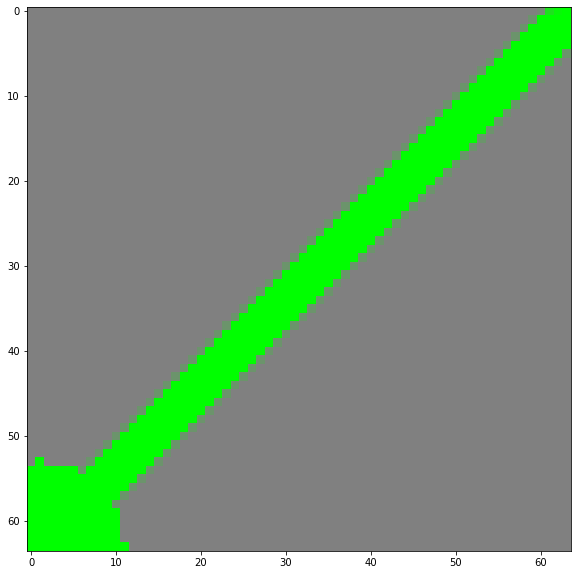

In [264]:
'''
This code creates lines with a given source
'''

#Constants
WINDOW_SIZE = (64, 64) 
ROPE_RADIUS = 2

# Mapping cardinal directions to approximate angles (in radians)
# Starting N at -90 degrees (standard Cartesian setup in image space)
DIRECTIONS = {
    "N":  -math.pi/2, "NE": -math.pi/4, "E": 0, "SE": math.pi/4,
    "S":   math.pi/2, "SW": 3*math.pi/4, "W": math.pi, "NW": -3*math.pi/4
}
DIR_KEYS = list(DIRECTIONS.keys())


def get_boundary_point(angle, size):
    """Calculates where a line at 'angle' hits the image boundary."""
    h, w = size
    cx, cy = w // 2, h // 2
    
    # Large distance to ensure we hit the boundary
    dist = max(w, h)
    
    x1 = int(cx - dist * math.cos(angle))
    y1 = int(cy - dist * math.sin(angle))
    x2 = int(cx + dist * math.cos(angle))
    y2 = int(cy + dist * math.sin(angle))
    
    _,p1,p2 = cv2.clipLine((0, 0, w, h), (x1, y1), (x2, y2))
    return [p1,p2] 


#This function Draws a line going thorugh the center given the angle
def draw_strand(img, angle, thickness):
    """Draws a smooth 'rope' strand through the center."""
    h, w = img.shape[:2]
    cx, cy = w // 2, h // 2
    
    p_in, p_out= get_boundary_point(angle, (h, w))
    
    cv2.line(img, p_in, p_out, (0,255,0), thickness, cv2.LINE_AA)
    cv2.circle(img,p_in, 10, (0,255,0), -1)
    return p_in, p_out


# Initialize a clean, gray background
img = np.full((WINDOW_SIZE[1], WINDOW_SIZE[0], 3), 128, dtype=np.uint8)

# 4. Create the plot
plt.figure(figsize=(10, 10))
plt.imshow(img)


# 1. Randomize standard movement (The "Main Strand")
in_idx = random.randint(0, 7)
angle = DIRECTIONS[DIR_KEYS[in_idx]]



draw_strand(img, angle, ROPE_RADIUS * 2)

plt.imshow(img)

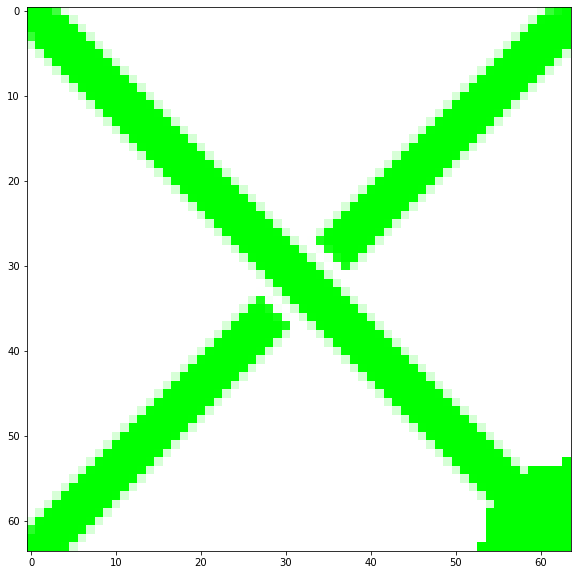

In [265]:
'''
This code creates lines with a given source
'''
#Constants
WINDOW_SIZE = (64, 64) 
THICKNESS = 2

# Mapping cardinal directions to approximate angles (in radians)
# Starting N at -90 degrees (standard Cartesian setup in image space)
DIRECTIONS = {
    "N":  -math.pi/2, "NE": -math.pi/4, "E": 0, "SE": math.pi/4,
    "S":   math.pi/2, "SW": 3*math.pi/4, "W": math.pi, "NW": -3*math.pi/4
}
DIR_KEYS = list(DIRECTIONS.keys())


def get_boundary_point(angle, size):
    """Calculates where a line at 'angle' hits the image boundary."""
    h, w = size
    cx, cy = w // 2, h // 2
    
    # Large distance to ensure we hit the boundary
    dist = max(w, h)
    
    x1 = int(cx - dist * math.cos(angle))
    y1 = int(cy - dist * math.sin(angle))
    x2 = int(cx + dist * math.cos(angle))
    y2 = int(cy + dist * math.sin(angle))
    
    _,p1,p2 = cv2.clipLine((0, 0, w, h), (x1, y1), (x2, y2))
    return [p1,p2] 


#This function Draws a line going thorugh the center given the angle
def draw_strand(img, angle, thickness, isMain):
    """Draws a smooth 'rope' strand through the center."""
    h, w = img.shape[:2]
    cx, cy = w // 2, h // 2
    
    p_in, p_out= get_boundary_point(angle, (h, w))
    
    cv2.line(img, p_in, p_out, (0,255,0), thickness, cv2.LINE_AA)
    if isMain: cv2.circle(img,p_in, 10, (0,255,0), -1)
    return p_in, p_out

def draw_over_strand(img, angle, thickness, isMain):
    """Draws a smooth 'rope' strand through the center."""
    h, w = img.shape[:2]
    cx, cy = w // 2, h // 2
    
    p_in, p_out= get_boundary_point(angle, (h, w))
    
    cv2.line(img, p_in, p_out, (255,255,255), thickness+4, cv2.LINE_AA)
    cv2.line(img, p_in, p_out, (0,255,0), thickness, cv2.LINE_AA)
    if isMain: cv2.circle(img,p_in, 10, (0,255,0), -1)
    return p_in, p_out


# Initialize a clean, gray background
img = np.full((WINDOW_SIZE[1], WINDOW_SIZE[0], 3), -1, dtype=np.uint8)

# 4. Create the plot
plt.figure(figsize=(10, 10))
plt.imshow(img)


idx1 = random.randint(0, 7)
idx2 = random.randint(0, 7)

angle1 = DIRECTIONS[DIR_KEYS[(idx1 + 2) % 8]]
angle2 = DIRECTIONS[DIR_KEYS[(idx2 + 2) % 8]]


# Draw secondary strand FIRST (it goes underneath)
draw_strand(img, angle1, ROPE_RADIUS * 2, False)
# Draw primary strand SECOND (it goes on top)
draw_over_strand(img, angle2, ROPE_RADIUS * 2, True)




plt.imshow(img)